In [1]:
# Pneumonia Detection from Chest X-Ray Images
# Using Deep Learning

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import zipfile
import shutil
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Download and extract dataset
!wget -q https://d3ilbtxij3aepc.cloudfront.net/projects/CNN-PROJECT-7-11/Chest-Xray-2.zip
!unzip -q Chest-Xray-2.zip

In [4]:
# Check directory structure
!ls -la chest_xray

total 20
drwxr-xr-x 5 root root 4096 May 22 15:00 .
drwxr-xr-x 1 root root 4096 May 22 15:00 ..
drwxr-xr-x 4 root root 4096 May 22 15:00 test
drwxr-xr-x 4 root root 4096 May 22 15:00 train
drwxr-xr-x 4 root root 4096 May 22 15:00 val


In [5]:
# Define paths
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

In [6]:
# Count images in each directory
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal, pneumonia

train_normal, train_pneumonia = count_images(train_dir)
if os.path.exists(val_dir):
    val_normal, val_pneumonia = count_images(val_dir)
else:
    val_normal, val_pneumonia = 0, 0
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training: Normal={train_normal}, Pneumonia={train_pneumonia}")
print(f"Validation: Normal={val_normal}, Pneumonia={val_pneumonia}")
print(f"Testing: Normal={test_normal}, Pneumonia={test_pneumonia}")

Training: Normal=1342, Pneumonia=3876
Validation: Normal=9, Pneumonia=9
Testing: Normal=234, Pneumonia=390


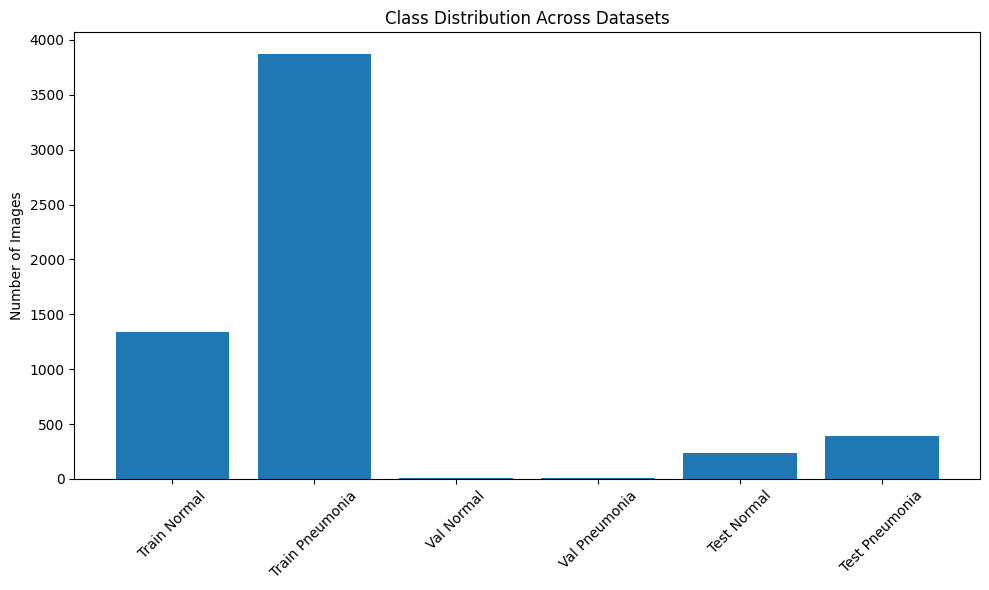

In [7]:
# Plot distribution of classes
plt.figure(figsize=(10, 6))
plt.bar(['Train Normal', 'Train Pneumonia', 'Val Normal', 'Val Pneumonia', 'Test Normal', 'Test Pneumonia'],
        [train_normal, train_pneumonia, val_normal, val_pneumonia, test_normal, test_pneumonia])
plt.title('Class Distribution Across Datasets')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

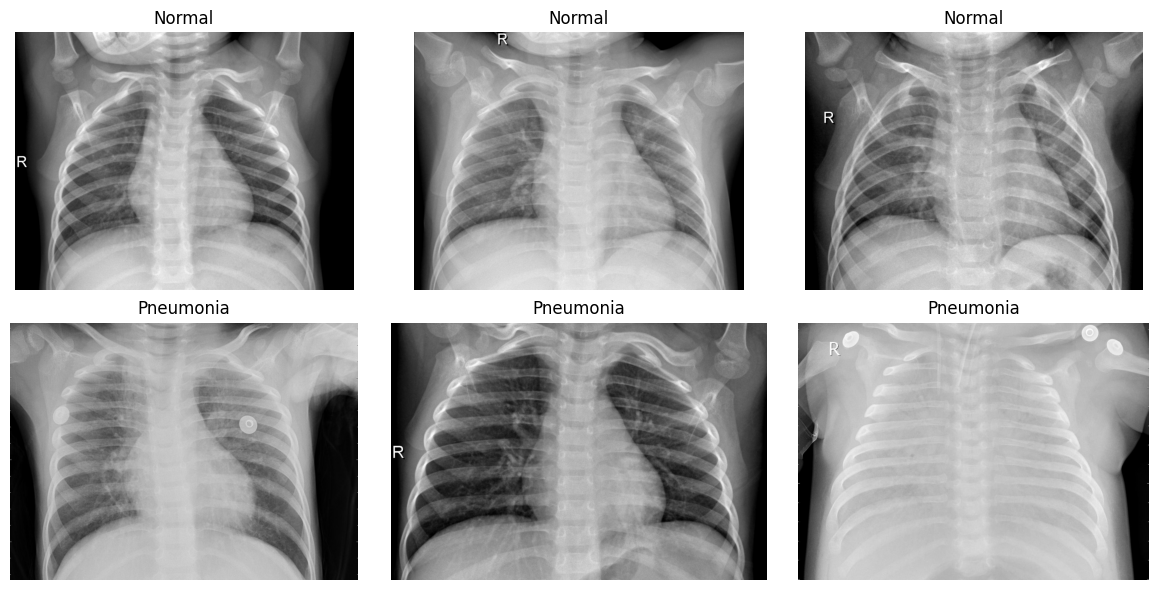

In [8]:
# Visualize some sample images
def plot_samples(normal_dir, pneumonia_dir):
    plt.figure(figsize=(12, 6))

    for i, img_path in enumerate(random.sample(os.listdir(normal_dir), 3)):
        img = Image.open(os.path.join(normal_dir, img_path)).convert('L')
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title('Normal')
        plt.axis('off')

    for i, img_path in enumerate(random.sample(os.listdir(pneumonia_dir), 3)):
        img = Image.open(os.path.join(pneumonia_dir, img_path)).convert('L')
        plt.subplot(2, 3, i+4)
        plt.imshow(img, cmap='gray')
        plt.title('Pneumonia')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_samples(train_dir + '/NORMAL', train_dir + '/PNEUMONIA')

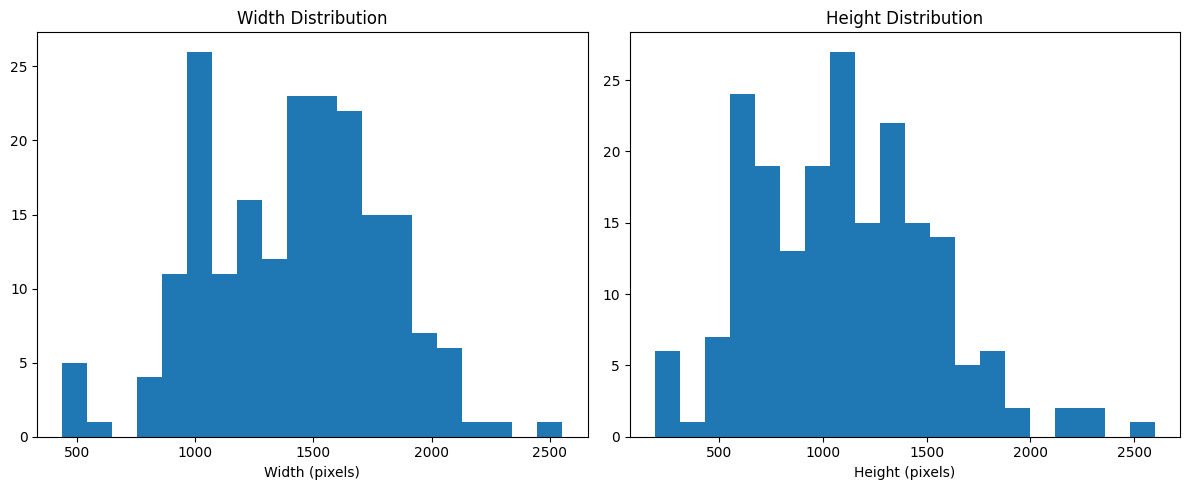

Average width: 1417.87 pixels
Average height: 1095.69 pixels
Min width: 438 pixels, Max width: 2553 pixels
Min height: 190 pixels, Max height: 2601 pixels


In [9]:
# Image size analysis
def analyze_image_sizes(directory):
    widths = []
    heights = []
    for class_dir in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(directory, class_dir)
        files = os.listdir(class_path)
        for file in random.sample(files, min(100, len(files))):  # Sample up to 100 images
            img = Image.open(os.path.join(class_path, file))
            widths.append(img.width)
            heights.append(img.height)

    return widths, heights

widths, heights = analyze_image_sizes(train_dir)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20)
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20)
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

print(f"Average width: {np.mean(widths):.2f} pixels")
print(f"Average height: {np.mean(heights):.2f} pixels")
print(f"Min width: {np.min(widths)} pixels, Max width: {np.max(widths)} pixels")
print(f"Min height: {np.min(heights)} pixels, Max height: {np.max(heights)} pixels")


In [10]:
# Define image dimensions for the model
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [11]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


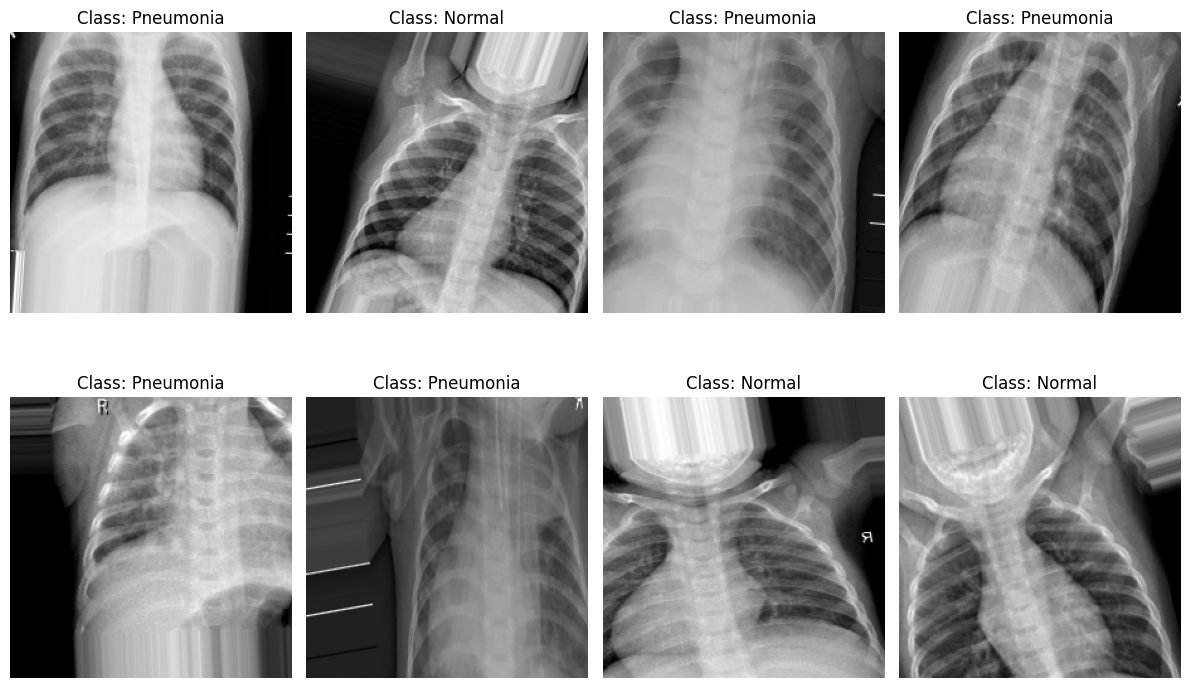

In [13]:
# Visualize augmented images
def show_augmented_images():
    x_batch, y_batch = next(train_generator)
    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(x_batch))):
        plt.subplot(2, 4, i+1)
        plt.imshow(x_batch[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.title(f"Class: {'Pneumonia' if y_batch[i] > 0.5 else 'Normal'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_images()

In [14]:
# Define CNN model
def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten and fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (Pneumonia vs Normal)
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

# Create and summarize model
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,671,521 (197.11 MB)

 Trainable params: 51,669,601 (197.10 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
# Calculate class weights to handle imbalance
total_train = train_normal + train_pneumonia
weight_normal = (1 / train_normal) * (total_train / 2)
weight_pneumonia = (1 / train_pneumonia) * (total_train / 2)
class_weights = {0: weight_normal, 1: weight_pneumonia}
print(f"Class weights: {class_weights}")

Class weights: {0: 1.9441132637853948, 1: 0.6731166150670794}


In [16]:
# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('pneumonia_model.h5', save_best_only=True, monitor='val_loss')
]

In [17]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [18]:
 # Train model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7730 - auc: 0.8905 - loss: 0.4946 - precision: 0.9443 - recall: 0.7354

163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 410ms/step - accuracy: 0.7733 - auc: 0.8907 - loss: 0.4940 - precision: 0.9444 - recall: 0.7358 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 7.7184 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8579 - auc: 0.9384 - loss: 0.3437 - precision: 0.9608 - recall: 0.8444

163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 403ms/step - accuracy: 0.8580 - auc: 0.9384 - loss: 0.3436 - precision: 0.9608 - recall: 0.8444 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 5.7604 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8877 - auc: 0.9549 - loss: 0.2739 - precision: 0.9635 - recall: 0.8831

163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 436ms/step - accuracy: 0.8877 - auc: 0.9549 - loss: 0.2739 - precision: 0.9635 - recall: 0.8831 - val_accuracy: 0.6250 - val_auc: 0.6719 - val_loss: 0.8126 - val_precision: 0.6250 - val_recall: 0.6250 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9044 - auc: 0.9691 - loss: 0.2205 - precision: 0.9726 - recall: 0.8959

163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 646ms/step - accuracy: 0.9044 - auc: 0.9691 - loss: 0.2205 - precision: 0.9726 - recall: 0.8959 - val_accuracy: 0.5625 - val_auc: 0.5547 - val_loss: 0.7356 - val_precision: 0.6000 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 360ms/step - accuracy: 0.9113 - auc: 0.9694 - loss: 0.2219 - precision: 0.9756 - recall: 0.9017 - val_accuracy: 0.5000 - val_auc: 0.5625 - val_loss: 8.3381 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 357ms/step - accuracy: 0.9040 - auc: 0.9678 - loss: 0.2238 - precision: 0.9760 - recall: 0.8936 - val_accuracy: 0.5625 - val_auc: 0.7734 - val_loss: 1.5812 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.9055 - auc: 0.9670 - loss: 0.2275 - precision: 0.9697 - recall: 0.9017 - val_accuracy: 0.5000 - val_auc: 0.6797 - val_loss: 1.5342 - v

163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 438ms/step - accuracy: 0.9378 - auc: 0.9825 - loss: 0.1619 - precision: 0.9824 - recall: 0.9334 - val_accuracy: 0.4375 - val_auc: 0.5625 - val_loss: 0.6727 - val_precision: 0.4000 - val_recall: 0.2500 - learning_rate: 5.0000e-04
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 358ms/step - accuracy: 0.9323 - auc: 0.9834 - loss: 0.1602 - precision: 0.9845 - recall: 0.9234 - val_accuracy: 0.5625 - val_auc: 0.6953 - val_loss: 2.0826 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 5.0000e-04
Epoch 13/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 356ms/step - accuracy: 0.9295 - auc: 0.9829 - loss: 0.1633 - precision: 0.9780 - recall: 0.9263 - val_accuracy: 0.6250 - val_auc: 0.6094 - val_loss: 5.3938 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 14/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 358ms/step - accuracy: 0.9228 - auc: 0.9792 - loss: 0.1801 - precision: 0.9841 - recall: 0.9103 - val_accuracy: 0.5625 - val_auc: 0.5625 - val_lo

163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 468ms/step - accuracy: 0.9417 - auc: 0.9879 - loss: 0.1352 - precision: 0.9894 - recall: 0.9310 - val_accuracy: 0.8750 - val_auc: 0.9375 - val_loss: 0.3902 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 2.5000e-04
Epoch 20/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 355ms/step - accuracy: 0.9481 - auc: 0.9881 - loss: 0.1361 - precision: 0.9851 - recall: 0.9440 - val_accuracy: 0.5625 - val_auc: 0.6875 - val_loss: 2.2574 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 21/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 351ms/step - accuracy: 0.9394 - auc: 0.9872 - loss: 0.1366 - precision: 0.9825 - recall: 0.9348 - val_accuracy: 0.6250 - val_auc: 0.7500 - val_loss: 1.7502 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 22/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 354ms/step - accuracy: 0.9454 - auc: 0.9876 - loss: 0.1349 - precision: 0.9824 - recall: 0.9437 - val_accuracy: 0.5625 - val_auc: 0.7812 - val_lo

163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 618ms/step - accuracy: 0.9546 - auc: 0.9907 - loss: 0.1100 - precision: 0.9914 - recall: 0.9479 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.3170 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 1.2500e-04
Epoch 27/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 356ms/step - accuracy: 0.9455 - auc: 0.9900 - loss: 0.1225 - precision: 0.9866 - recall: 0.9400 - val_accuracy: 0.8750 - val_auc: 0.9375 - val_loss: 0.4314 - val_precision: 1.0000 - val_recall: 0.7500 - learning_rate: 1.2500e-04
Epoch 28/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - accuracy: 0.9515 - auc: 0.9895 - loss: 0.1255 - precision: 0.9898 - recall: 0.9441 - val_accuracy: 0.5625 - val_auc: 0.8750 - val_loss: 1.1295 - val_precision: 1.0000 - val_recall: 0.1250 - learning_rate: 1.2500e-04
Epoch 29/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 364ms/step - accuracy: 0.9588 - auc: 0.9940 - loss: 0.0967 - precision: 0.9908 - recall: 0.9530 - val_accuracy: 0.5000 - val_auc: 0.8125 - val_l

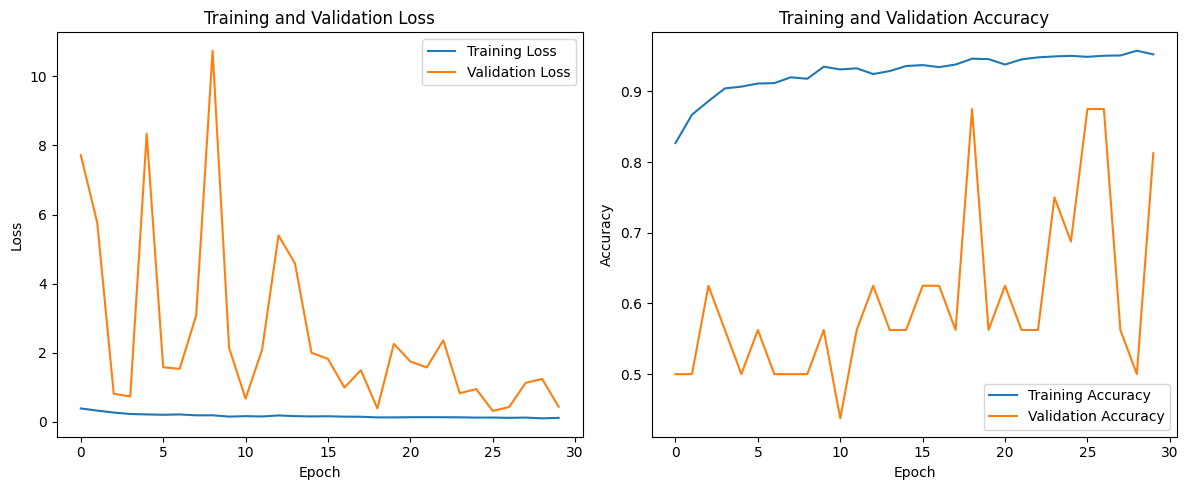

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


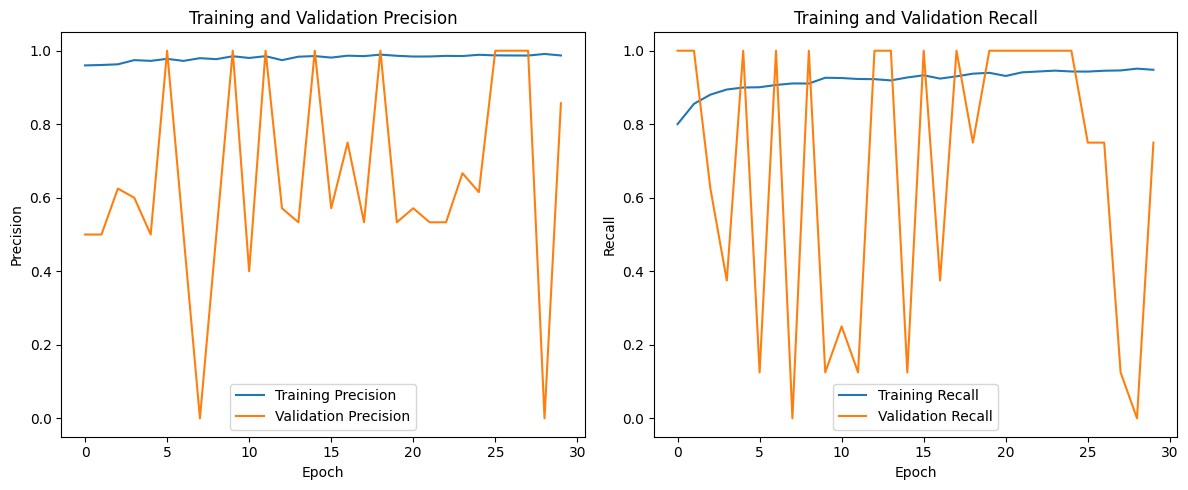

In [20]:
# Additional metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# Evaluate model on test set
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.8888 - auc: 0.6310 - loss: 0.3221 - precision: 0.5555 - recall: 0.5590
Test Accuracy: 0.8638
Test Precision: 0.9320
Test Recall: 0.8436
Test AUC: 0.9462


In [1]:
# Get predictions
test_generator.reset()

# Make sure steps is an integer
steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

y_pred = model.predict(test_generator, steps=steps)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

NameError: name 'test_generator' is not defined

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['Normal', 'Pneumonia']))


In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Visualize some predictions
def display_predictions(model, generator, n=6):
    # Get batch of test images
    generator.reset()
    batch_x, batch_y = next(generator)

    # Get predictions
    preds = model.predict(batch_x)
    preds = (preds > 0.5).astype(int).flatten()

    # Display
    plt.figure(figsize=(15, 10))
    for i in range(min(n, len(batch_x))):
        plt.subplot(2, 3, i+1)
        plt.imshow(batch_x[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        actual = 'Pneumonia' if batch_y[i] > 0.5 else 'Normal'
        predicted = 'Pneumonia' if preds[i] > 0.5 else 'Normal'
        title_color = 'green' if actual == predicted else 'red'
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_predictions(model, test_generator)

In [ ]:
# Function to make predictions on new images
def predict_image(image_path, model):
    # Load and preprocess image
    img = Image.open(image_path).convert('L')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    predicted_class = 'Pneumonia' if prediction > 0.5 else 'Normal'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example usage:
# predict_image('path_to_new_image.jpg', model)

# Save model
model.save('pneumonia_detection_model.h5')
print("Model saved successfully!")